In [1]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 568046008610638147
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11330676327
locality {
  bus_id: 1
}
incarnation: 17018941739974910122
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:17.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 11330614068
locality {
  bus_id: 1
}
incarnation: 4676369823371915339
physical_device_desc: "device: 1, name: Tesla K80, pci bus id: 0000:00:18.0"
, name: "/gpu:2"
device_type: "GPU"
memory_limit: 11330676327
locality {
  bus_id: 1
}
incarnation: 14285452485812993932
physical_device_desc: "device: 2, name: Tesla K80, pci bus id: 0000:00:19.0"
, name: "/gpu:3"
device_type: "GPU"
memory_limit: 11328684032
locality {
  bus_id: 1
}
incarnation: 6534548435709143190
physical_device_desc: "device: 3, name: Tesla K80, pci bus id: 0000:00:1a.0"
, name: "/gpu:4"
device_type: "GPU"
memory_limit: 11328684032
locality {
  bus_id: 1
}
incarnation: 427023

In [1]:
from keras import backend as K
import keras.utils.np_utils

from keras.models import Sequential
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, ZeroPadding1D
from keras.applications.vgg16 import VGG16

from keras. preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import numpy as np
import pandas as pd

from IPython.display import SVG
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import sys
from IPython.display import display 



#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:17.0)


In [2]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255, horizontal_flip=True)

In [8]:
def plot_images(x, y, **kwargs):
    n_pix = int(np.sqrt(np.prod(x.shape[1:3]))) #assumes images are square
    im_indices = np.random.choice(x.shape[0], 36, replace=False)
    fig, axes = subplots(nrows=6,ncols=6, figsize=(10,10), sharex=True, sharey=True, frameon=False)
    for i,ax in enumerate(axes.flat):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        curr_i = im_indices[i]
        curr_label = label[argmax(y[curr_i])]
        ax.imshow(x[curr_i].reshape(n_pix,n_pix, 3), aspect="auto", **kwargs)
        ax.text(10,20,curr_label, fontdict={"backgroundcolor": "gray","color": "white" })
#         ax.set_title(title)
        ax.axis('off')
    plt.tight_layout(h_pad=0, w_pad=0)

Populating the interactive namespace from numpy and matplotlib
Found 149530 images belonging to 101 classes.
Found 64025 images belonging to 101 classes.


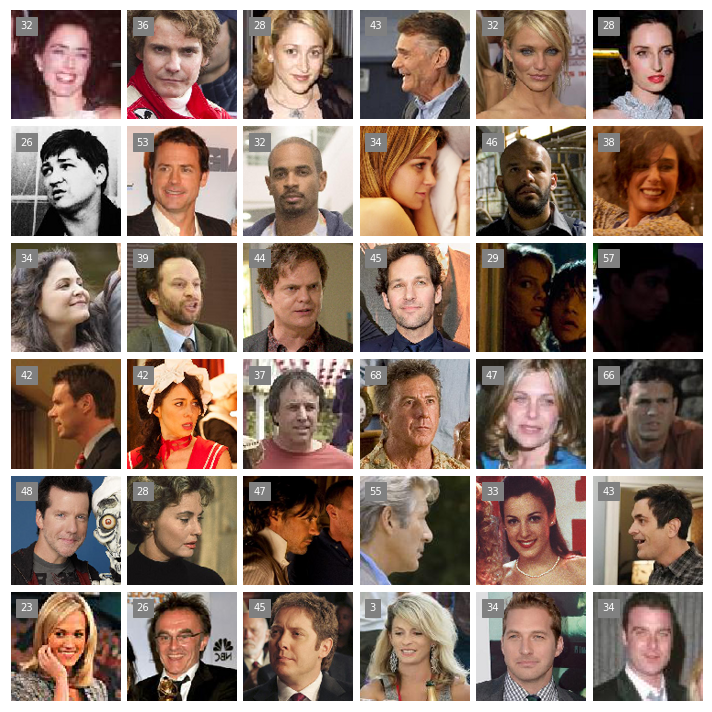

In [9]:
%pylab inline
IMSIZE = [120, 120]
BATCH  =  64

train_gentrain_g  = datagen.flow_from_directory(
    directory='images/imdb_crop/test_train/train',
    target_size=IMSIZE,
    batch_size=BATCH,
)

val_gen = datagen.flow_from_directory(
    directory='images/imdb_crop/test_train/test',
    target_size=IMSIZE,
    batch_size=BATCH,
)
x,y = next(train_gentrain_g)

plot_images(x, y, interpolation="spline16")

In [18]:
print(x.shape)

(64, 120, 120, 3)


In [5]:
#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet',pooling='avg', include_top=False)


#model_vgg16_conv.summary()

# Tailor our input format (Note- Tensorflow input order!)
input = Input(shape=(120,120,3),name = 'image_input')  # our input shape: (32,32,3)

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

#Add the fully-connected layers 
#x = Flatten(name='flatten')
x = Dense(500, activation='relu', name='fc1')(output_vgg16_conv)
x = Dense(500, activation='relu', name='fc2')(x)
x = Dense(1, activation='linear', name='predictions')(x)

#Create your own model 
my_model = Model(input=input, output=x)  # Using the Functional API
# Freeze convolutional layers
for layer in my_model.layers[:2]:
    layer.trainable=False

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/image_inp..., outputs=Elemwise{a...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 120, 120, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
fc1 (Dense)                  (None, 500)               256500    
_________________________________________________________________
fc2 (Dense)                  (None, 500)               250500    
_________________________________________________________________
predictions (Dense)          (None, 1)                 501       
Total params: 15,222,189
Trainable params: 507,501
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
from sklearn.metrics import r2_score



In [23]:
def custom_metric(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred))



In [6]:
# must use a very small learning rate 
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

my_model.compile(optimizer='adam', loss='mean_squared_error')


In [38]:
import glob

glob.glob('/home/ubuntu/project_pi/model/*')

[]

In [ ]:
# prepare data augmentation configuration 
test_steps = val_gen.n//val_gen.batch_size
train_steps = train_gentrain_g.n//train_gentrain_g.batch_size




# same callbacks!
cb_a=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
# lets look at our results while we are at it
cb_b=keras.callbacks.ReduceLROnPlateau(factor=.5, patience=2, min_lr=1e-8)
#cb_c = keras.callbacks.ModelCheckpoint('/home/ubuntu/project_pi/model/weights.hdf5', monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# fine-tune the model
my_model.fit_generator(
    train_gentrain_g,
    steps_per_epoch= train_steps,
    nb_epoch=1,
    validation_data=val_gen,
    validation_steps=  test_steps,
    callbacks=[cb_b, cb_a])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=5032, validation_data=<keras_pre..., validation_steps=2155, callbacks=[<keras.ca..., epochs=1)`


Epoch 1/1
5004/5032 [============================>.] - ETA: 10s - loss: 198.6074

In [119]:
glob.glob('/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/*')

['/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/nm4314944_rm976596224_2010-2-12_2010.jpg',
 '/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/nm0837177_rm1374792704_1975-9-18_1975.jpg',
 '/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/nm1940545_rm1081919488_1984-0-0_1984.jpg',
 '/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/nm4314944_rm3593055744_2010-2-12_2010.jpg',
 '/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/nm1377375_rm2251480064_1981-8-25_1981.jpg',
 '/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/nm1940545_rm1971235584_1984-0-0_1984.jpg',
 '/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/nm0837177_rm642889984_1975-9-18_1975.jpg',
 '/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/nm0837177_rm2483204352_1975-9-18_1975.jpg',
 '/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/nm0837177_rm1901958144_1975-9-18_1975.jpg',
 '/home/ubuntu/project_pi/images/imdb_crop/test_train/test/

In [70]:
my_model.save('model.hdf5')

In [99]:
from keras.models import load_model


model = load_model('model.hdf5')

img = cv2.imread('/home/ubuntu/project_pi/images/imdb_crop/test_train/test/22/nm1065229_rm148540928_1984-4-18_2006.jpg',
)
img = cv2.resize(img,(120,120))
img = np.reshape(img,[1,120,120,3])

classes = model.predict(img)

print(classes)



/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


[[ 0.01164423 -0.1802891  -0.09755193  0.17421657 -0.13667493  0.16212626
  -0.08701596  0.06558889  0.05615257  0.14941652  0.12870142 -0.11416841
   0.16333005  0.086407    0.11961192  0.0007626   0.09293583  0.05191983
   0.00270722  0.04845295 -0.10378265  0.00613429  0.11051047  0.21456254
   0.03023696  0.18035944  0.16044788  0.0196585   0.20740943  0.1649476
   0.20008467  0.18303676  0.13157144  0.01615983  0.0884124   0.05245295
  -0.18990712  0.14400125  0.08098938  0.02345417 -0.00188966  0.0318303
  -0.08121784  0.17210983 -0.05699618  0.0198346  -0.0668908   0.13705881
   0.17337376  0.22427861  0.12017034  0.12627658 -0.04345924 -0.00874767
   0.1286557  -0.00804777  0.10585808  0.01104796 -0.09769687 -0.1473266
   0.18767823  0.02705213 -0.10703108  0.2014538  -0.02432654  0.01659647
  -0.00577159  0.05224003 -0.17113589  0.20328519  0.09657602 -0.13089237
  -0.14726737 -0.00258125  0.13994704  0.19552243  0.12507422 -0.11641677
   0.01792875 -0.03554729  0.12797752  0.

In [111]:
img = cv2.imread('/home/ubuntu/project_pi/images/imdb_crop/test_train/test/33/nm0000496_rm3777730816_1973-6-21_2006.jpg')
img = cv2.resize(img,(120,120))
img = np.reshape(img,[1,120,120,3])
 
predict = model.predict(img, verbose=1)

Z = [x for _,x in sorted(zip(label,predict[0]))]
argmax(Z)


1/1 [==============================] - 0s 27ms/step


4

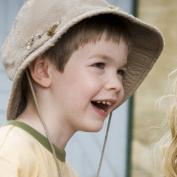

In [110]:
from IPython.display import Image
Image(filename='/home/ubuntu/project_pi/images/imdb_crop/test_train/test/33/nm0000496_rm3777730816_1973-6-21_2006.jpg') 

In [127]:
img = cv2.imread('/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/nm0837177_rm1374792704_1975-9-18_1975.jpg')
img = cv2.resize(img,(120,120))
img = np.reshape(img,[1,120,120,3])
 
predict = model.predict(img, verbose=1)

Z = [x for _,x in sorted(zip(label,predict[0]))]
argmax(Z)


1/1 [==============================] - 0s 27ms/step


5

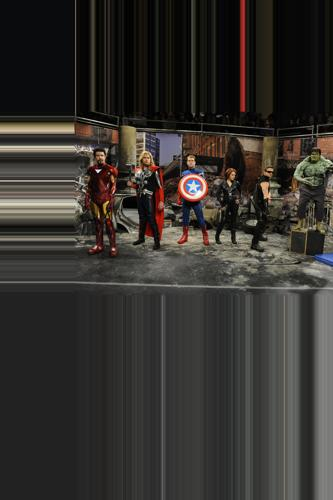

In [129]:
from IPython.display import Image
Image(filename= '/home/ubuntu/project_pi/images/imdb_crop/test_train/test/0/nm0837177_rm1374792704_1975-9-18_1975.jpg')

In [4]:
import scipy.io
mat = scipy.io.loadmat('images/imdb_crop/imdb.mat')
lon = mat['lon']
lat = mat['lat']
# one-liner to read a single variable
lon = loadmat('images/imdb_crop/imdb.mat')['lon']

KeyError: 'lon'

In [ ]:
glob.glob()

In [ ]:
from IPython.display import Image
Image(filename='/home/ubuntu/project_pi/images/imdb_crop/00/nm0000100_rm1002674432_1955-1-6_2003.jpg') 